# Demo: Seismic Regularization

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pylops

from scipy.signal import convolve
from pylops.optimization.sparsity import FISTA
from pyctlops import FDCT2D

np.random.seed(0)

In [2]:
inputfile = '../testdata/seismic.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, ::2]
x = x/np.abs(x).max()
taxis, xaxis = inputdata['t'][::2], inputdata['r'][0]

par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = inputdata['wav'][::2]
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# subsampling locations
perc_subsampling = 0.5
Nsub = int(np.round(par['nx']*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# restriction operator
Rop = pylops.Restriction(par['nx']*par['nt'], iava,
                         dims=(par['nx'], par['nt']),
                         dir=0, dtype='float64')

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()

y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape(par['nx'], par['nt'])

# apply mask
ymask = Rop.mask(x.flatten())

### Curvelet transform

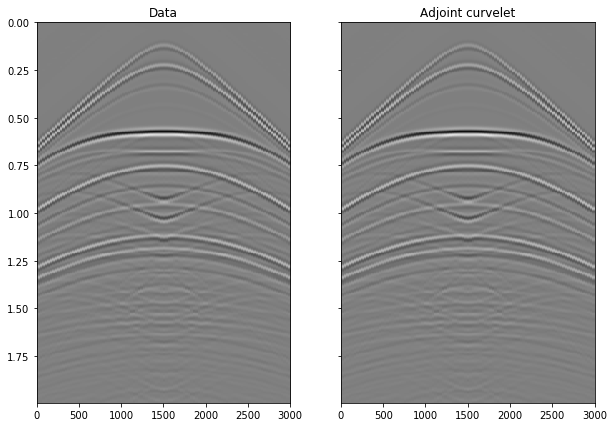

In [3]:
DCTOp = FDCT2D((par['nx'], par['nt']))

yc = DCTOp * x.ravel()
xcadj = DCTOp.H * yc
xcadj = xcadj.reshape(par['nx'], par['nt'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
axs[0].imshow(x.T, cmap='gray', vmin=-0.1, vmax=0.1,
             extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(np.real(xcadj).T, cmap='gray', vmin=-0.1, vmax=0.1,
             extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[1].set_title('Adjoint curvelet')
axs[1].axis('tight');

### Reconstruction based on Curvelet transform

In [4]:
# combined modelling operator
RCop = Rop*DCTOp.H

# inverse
pl1, _, cost = FISTA(RCop, y.ravel(), niter=300, eps=1e-3, returninfo=True, show=True)
        
xl1 = np.real(DCTOp.H * pl1)
xl1 = xl1.reshape(par['nx'], par['nt'])

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 20000 rows and 305683 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 300
alpha = 1.000000e+00	thresh = 5.000000e-04
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1  -7.49856e-04   1.067e-02   2.690e-01   1.383e+00
     2  -9.11623e-04   9.923e-03   2.541e-01   8.676e-02
     3  -1.03803e-03   9.270e-03   2.408e-01   9.289e-02
     4  -1.16937e-03   8.703e-03   2.293e-01   9.611e-02
     5  -1.23733e-03   8.240e-03   2.191e-01   9.767e-02
     6  -1.25158e-03   7.846e-03   2.104e-01   9.769e-02
     7  -1.24314e-03   7.534e-03   2.028e-01   9.678e-02
     8  -1.22797e-03   7.286e-03   1.963e-01   9.516e-02
     9  -1.21377e-03   7.091e-03   1.906e-01   9.344e-02
    10  -1.20853e-03   6.910e-03   1.856e-01   9.125e-02
    11  -1.21470e-03   6.755e-03   1.814e-01   8.857e-02
    21  -1.24385e

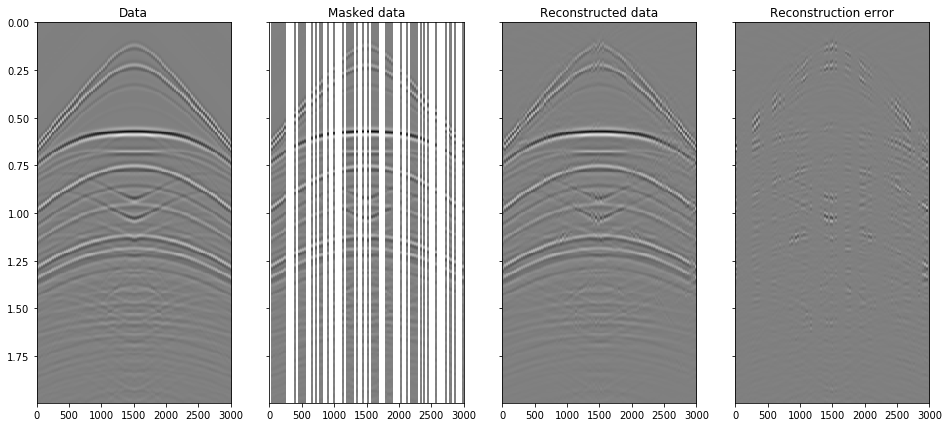

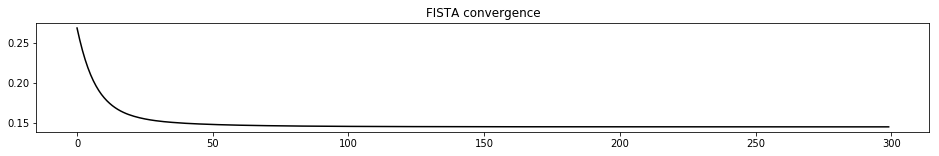

In [5]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16, 7))
axs[0].imshow(x.T, cmap='gray', vmin=-0.1, vmax=0.1,
                 extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.1, vmax=0.1,
                 extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(np.real(xl1).T, cmap='gray', vmin=-0.1, vmax=0.1,
              extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[2].set_title('Reconstructed data')
axs[2].axis('tight')
axs[3].imshow(x.T - np.real(xl1).T, cmap='gray', vmin=-0.1, vmax=0.1,
              extent=(xaxis[0], xaxis[-1], taxis[-1], taxis[0]))
axs[3].set_title('Reconstruction error')
axs[3].axis('tight');

plt.figure(figsize=(16, 2))
plt.plot(cost, 'k' )
plt.title('FISTA convergence');